# Question 1

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the Skipgram model
2. Using CBOW model
3. Analyze the different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings
    - Visualize your results and interpret your results
4. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What are the main drawbacks of CBOW and Skipgram?


In [6]:
from __future__ import division
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from itertools import islice
from matplotlib import pylab, pyplot


# additional imports
import operator
import re
from sklearn.decomposition import PCA

In [7]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
# corpus = open(path).readlines()[0:700]
corpus = open(path).readlines()

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
# print(corpus)

embedded_dim = [50, 150, 300]
window_size = 2

In [9]:
#prepare data for Skipgram
def generate_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for sentence in corpus: #looping over the sentences
        L = len(sentence)
        for index, word in enumerate(sentence): #for each index-word pair in enum(sentence)
            p = index - window_size
            n = index + window_size + 1
                    
            for i in range(p, n): #iterating over part of the sentence with given window size
                if i != index and 0 <= i < L:
                    # Add the input word
                    #in_words.append(word)
                    all_in.append(word) # the 'central' word
                    # Add one of the context words
                    all_out.append(np_utils.to_categorical(sentence[i], V)) #to_categorical converts a class vector (i.e. words) to binary class matrix, i.e. 1-of-V encoding
                    
                                   
    return (np.array(all_in),np.array(all_out))
    

In [10]:
#generate training data
x,y = generate_skipgram(corpus,window_size,V)

In [11]:
def train_skipGram(embedded_dim):
    embedded_dim= embedded_dim
    print('EMBEDDING DIMENSION = ', embedded_dim)
    #skipgram model
    skipgram = Sequential()
    skipgram.add(Embedding(input_dim=V, output_dim=embedded_dim, embeddings_initializer='glorot_uniform', input_length=1))
    skipgram.add(Reshape((embedded_dim, )))
    skipgram.add(Dense(input_dim=embedded_dim, units=V, kernel_initializer='uniform', activation='softmax'))
    skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')
    skipgram.fit(x, y, batch_size=128, epochs=10, verbose=1)
    return skipgram

def getEmbeddingMatrix_SkipGram(skipgram):
    f = open('vectors_skipgram.txt' ,'w')
    f.write(" ".join([str(V-1),str(embedded_dim)]))
    f.write("\n")

    vectors = skipgram.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()

    weights = skipgram.get_weights()
    print("Weights for the embedding layer: ",  weights[0].shape)
    print("Weights for the dense layer: ",  weights[1].shape)
    print("Biases for the dense layer: ",  weights[2].shape)

    # Get the embedding matrix
    embeddingSkipgram = weights[0]
    print('shape of embedding ', embeddingSkipgram.shape)
    # print(V)
    return embeddingSkipgram

In [12]:
def getEmbeddingsForAllDims(embedded_dim):
    skipgram= train_skipGram(embedded_dim)
    skipGramEmbedding= getEmbeddingMatrix_SkipGram(skipgram)
    print('shape of embedding: ', skipGramEmbedding.shape)
    return skipGramEmbedding

In [13]:
skipGramEmbedding50= getEmbeddingsForAllDims(50)

EMBEDDING DIMENSION =  50
Epoch 1/10
94556/94556 [==============================] - 42s 449us/step - loss: 7.5078
Epoch 2/10
94556/94556 [==============================] - 41s 434us/step - loss: 6.6817
Epoch 3/10
94556/94556 [==============================] - 41s 431us/step - loss: 6.2753
Epoch 4/10
94556/94556 [==============================] - 42s 447us/step - loss: 6.0958
Epoch 5/10
94556/94556 [==============================] - 41s 429us/step - loss: 5.9918
Epoch 6/10
94556/94556 [==============================] - 42s 441us/step - loss: 5.9213
Epoch 7/10
94556/94556 [==============================] - 41s 429us/step - loss: 5.8694
Epoch 8/10
94556/94556 [==============================] - 40s 426us/step - loss: 5.8290
Epoch 9/10
94556/94556 [==============================] - 21s 225us/step - loss: 5.7957
Epoch 10/10
94556/94556 [==============================] - 15s 156us/step - loss: 5.7674
Weights for the embedding layer:  (2557, 50)
Weights for the dense layer:  (50, 2557)
Biases 

In [14]:
skipGramEmbedding150= getEmbeddingsForAllDims(150)

EMBEDDING DIMENSION =  150
Epoch 1/10
94556/94556 [==============================] - 27s 291us/step - loss: 7.4324
Epoch 2/10
94556/94556 [==============================] - 29s 306us/step - loss: 6.5285
Epoch 3/10
94556/94556 [==============================] - 28s 295us/step - loss: 6.1702
Epoch 4/10
94556/94556 [==============================] - 28s 293us/step - loss: 6.0074
Epoch 5/10
94556/94556 [==============================] - 28s 294us/step - loss: 5.9088
Epoch 6/10
94556/94556 [==============================] - 29s 305us/step - loss: 5.8398
Epoch 7/10
94556/94556 [==============================] - 27s 291us/step - loss: 5.7869
Epoch 8/10
94556/94556 [==============================] - 29s 310us/step - loss: 5.7441
Epoch 9/10
94556/94556 [==============================] - 28s 295us/step - loss: 5.7091
Epoch 10/10
94556/94556 [==============================] - 27s 288us/step - loss: 5.6785
Weights for the embedding layer:  (2557, 150)
Weights for the dense layer:  (150, 2557)
Bias

In [15]:
skipGramEmbedding300= getEmbeddingsForAllDims(300)

EMBEDDING DIMENSION =  300
Epoch 1/10
94556/94556 [==============================] - 49s 520us/step - loss: 7.3743
Epoch 2/10
94556/94556 [==============================] - 48s 509us/step - loss: 6.4481
Epoch 3/10
94556/94556 [==============================] - 47s 499us/step - loss: 6.1112
Epoch 4/10
94556/94556 [==============================] - 45s 474us/step - loss: 5.9533
Epoch 5/10
94556/94556 [==============================] - 45s 478us/step - loss: 5.8548
Epoch 6/10
94556/94556 [==============================] - 50s 533us/step - loss: 5.7844
Epoch 7/10
94556/94556 [==============================] - 47s 493us/step - loss: 5.7308
Epoch 8/10
94556/94556 [==============================] - 48s 509us/step - loss: 5.6871
Epoch 9/10
94556/94556 [==============================] - 51s 544us/step - loss: 5.6491
Epoch 10/10
94556/94556 [==============================] - 58s 609us/step - loss: 5.6153
Weights for the embedding layer:  (2557, 300)
Weights for the dense layer:  (300, 2557)
Bias

In [23]:
# analogy function for returning top closest words
# input: embedded word, intended word, embedding matrix
# returns: top n words found
def analogy_function(embedded_word, intended_word, embedding_matrix):
    distances = {}
    for i in range(embedding_matrix.shape[0]):
        # compute distance between embedded_word and each embedding_vector from the matrix
        distance = np.linalg.norm(embedded_word - embedding_matrix[i])
        distances[i] = distance
    index = min(distances, key=distances.get)
    return distances, vocabulary[index] == intended_word

#function for fetching the embedding matrix of a given word from the embedding vector
def embed(word, embedding, tokenizer=tokenizer):
    # get the index of the word from the tokenizer
    int_word = tokenizer.texts_to_sequences([word])[0]
    # get the size of the dictionary from the embedding matrix
    dict_size = embedding.shape[0]
    # get the one-hot encoding of the word
    bin_word = np_utils.to_categorical(int_word, dict_size)
    return np.dot(bin_word, embedding)

In [49]:
#SkipGram Results

def print_Results(embed_dim, embedding):
    print()
    print("Results with embedding dimension= ", embed_dim)
    print()
    embedding=embedding
    # do in-depth investigation with below two analogies for 'queen' and 'king'
    queen = embed('king', embedding) - embed('man', embedding) + embed('woman', embedding)
    king= embed('queen', embedding) - embed('woman', embedding) + embed('man', embedding)

    # binary and norm comparison between skip-gram and cbow only
    # with below to analogies for 'she' and 'he'
    she = embed('he', embedding) - embed('man', embedding) + embed('woman', embedding)
    he = embed('she', embedding) - embed('woman', embedding) + embed('man', embedding)

    distances_queen, correct_queen = analogy_function(queen, 'queen', embedding)
    distances_king, correct_king = analogy_function(king, 'king', embedding)
    distances_she, correct_she = analogy_function(she, 'she', embedding)
    distances_he, correct_he = analogy_function(he, 'he', embedding)

#     print(correct_queen, correct_king, correct_she, correct_he)

    # sort distance dictionaries so we have the indexes of the closest vectors on top
    distances_queen = sorted(distances_queen.items(), key=operator.itemgetter(1))
    distances_king = sorted(distances_king.items(), key=operator.itemgetter(1))
    distances_she = sorted(distances_she.items(), key=operator.itemgetter(1))
    distances_he = sorted(distances_he.items(), key=operator.itemgetter(1))

    # find at which index the correct word is
    for idx, word in vocabulary.items():
        if word == 'queen':
            index_queen = idx
        if word == 'king':
            index_king = idx
        if word == 'she':
            index_she = idx
        if word == 'he':
            index_he = idx

    # search dictionary for intended word and retrieve its index
    # length for all lists is V since they all cover the full vocabulary
    for i in range(V):
        if distances_queen[i][0] == index_queen:
            rank_on_list_queen = i + 1
        if distances_king[i][0] == index_king:
            rank_on_list_king = i + 1
        if distances_she[i][0] == index_she:
            rank_on_list_she = i + 1
        if distances_he[i][0] == index_he:
            rank_on_list_he = i + 1

    print('Rank of the word queen on sorted list of the words closest to the expected embedding of queen: ', rank_on_list_queen)
    print('Rank of the word king on sorted list of the words closest to the expected embedding of king: ', rank_on_list_king)
    print('Rank of the word she on sorted list of the words closest to the expected embedding of she: ', rank_on_list_she)
    print('Rank of the word he on sorted list of the words closest to the expected embedding of he: ', rank_on_list_he)
    print()
    
    #COSINE SIMILARITIES

    distance_queen_queen = np.linalg.norm(queen - embed('queen', embedding))
    distance_queen_woman = np.linalg.norm(queen - embed('woman', embedding))
    distance_king_king = np.linalg.norm(king - embed('king', embedding))
    distance_king_man = np.linalg.norm(king - embed('man', embedding))
    distance_she_she = np.linalg.norm(she - embed('she', embedding))
    distance_she_woman = np.linalg.norm(she - embed('woman', embedding))
    distance_he_he = np.linalg.norm(he - embed('he', embedding))
    distance_he_man = np.linalg.norm(she - embed('man', embedding))

    print('cosine similarity of queen, queen: ', distance_queen_queen)
    print('cosine similarity of queen, woman: ', distance_queen_woman)
    print('cosine similarity of king, king: ', distance_king_king)
    print('cosine similarity of king, man: ', distance_king_man)
    print('cosine similarity of she, she: ', distance_she_she)
    print('cosine similarity of she, woman: ', distance_she_woman)
    print('cosine similarity of he, he: ', distance_he_he)
    print('cosine similarity of he, man: ', distance_he_man)
    


In [50]:
#PRINT THE RESULTS OF ANALOGY FUNCTION FOR THE EMBEDDINGS OBTAINED FROM SKIPGRAM

print('shape of skipGramEmbedding50', skipGramEmbedding50.shape)
print('shape of skipGramEmbedding150', skipGramEmbedding150.shape)
print('shape of skipGramEmbedding300', skipGramEmbedding300.shape)

print('RESULTS OF ANALOGY FUNCTION FOR THE EMBEDDINGS OBTAINED FROM SKIPGRAM') 
print()
print_Results(50, skipGramEmbedding50)
print_Results(150, skipGramEmbedding150)
print_Results(300, skipGramEmbedding300)

shape of skipGramEmbedding50 (2557, 50)
shape of skipGramEmbedding150 (2557, 150)
shape of skipGramEmbedding300 (2557, 300)
RESULTS OF ANALOGY FUNCTION FOR THE EMBEDDINGS OBTAINED FROM SKIPGRAM


Results with embedding dimension=  50

Rank of the word queen on sorted list of the words closest to the expected embedding of queen:  4
Rank of the word king on sorted list of the words closest to the expected embedding of king:  6
Rank of the word she on sorted list of the words closest to the expected embedding of she:  836
Rank of the word he on sorted list of the words closest to the expected embedding of he:  3

cosine similarity of queen, queen:  0.7303677
cosine similarity of queen, woman:  1.596358
cosine similarity of king, king:  0.7303678
cosine similarity of king, man:  1.3678011
cosine similarity of she, she:  1.9563057
cosine similarity of she, woman:  1.9829371
cosine similarity of he, he:  1.9563057
cosine similarity of he, man:  2.0498924

Results with embedding dimension=  1

In [30]:
#prepare data for CBOW
def generate_data_cbow(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            p = index - window_size
            n = index + window_size + 1
        
            for i in range(p, n): #iterating over part of the sentence with given window size
                if i != index and 0 <= i < L:
                    all_in.append(sentence[i])
                    all_out.append(np_utils.to_categorical(word, V))
    return (np.array(all_in),np.array(all_out))

In [31]:
#generate training data 
x,y = generate_data_cbow(corpus,window_size,V)

In [32]:
def train_CBOW(embedded_dim):
    embedded_dim= embedded_dim
    print('EMBEDDING DIMENSION = ', embedded_dim)
    #CBOW model
    CBOW = Sequential()
    CBOW.add(Embedding(input_dim=V, output_dim=embedded_dim, embeddings_initializer='glorot_uniform', input_length=1))
    CBOW.add(Reshape((embedded_dim, )))
    CBOW.add(Dense(input_dim=embedded_dim, units=V, kernel_initializer='uniform', activation='softmax'))
    CBOW.compile(loss='categorical_crossentropy', optimizer='adadelta')
    CBOW.fit(x, y, batch_size=128, epochs=10, verbose=1)
    return CBOW

def getEmbeddingMatrix_CBOW(CBOW):
    f = open('vectors_CBOW.txt' ,'w')
    f.write(" ".join([str(V-1),str(embedded_dim)]))
    f.write("\n")

    vectors = CBOW.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write(word)
        f.write(" ")
        f.write(" ".join(map(str, list(vectors[i,:]))))
        f.write("\n")
    f.close()

    weights = CBOW.get_weights()
    print("Weights for the embedding layer: ",  weights[0].shape)
    print("Weights for the dense layer: ",  weights[1].shape)
    print("Biases for the dense layer: ",  weights[2].shape)

    # Get the embedding matrix
    embeddingCBOW = weights[0]
    print('shape of embedding ', embeddingCBOW.shape)
    # print(V)
    return embeddingCBOW

In [33]:

def getEmbeddingsForAllDims(embedded_dim):
    CBOW= train_CBOW(embedded_dim)
    CBOWEmbedding= getEmbeddingMatrix_CBOW(CBOW)
    print('shape of embedding: ', CBOWEmbedding.shape)
    return CBOWEmbedding
    

In [34]:
CBOWEmbedding50= getEmbeddingsForAllDims(50)


EMBEDDING DIMENSION =  50
Epoch 1/10
94556/94556 [==============================] - 20s 214us/step - loss: 7.5131
Epoch 2/10
94556/94556 [==============================] - 21s 223us/step - loss: 6.6791
Epoch 3/10
94556/94556 [==============================] - 21s 221us/step - loss: 6.2748
Epoch 4/10
94556/94556 [==============================] - 20s 214us/step - loss: 6.0966
Epoch 5/10
94556/94556 [==============================] - 20s 213us/step - loss: 5.9935
Epoch 6/10
94556/94556 [==============================] - 20s 212us/step - loss: 5.9238
Epoch 7/10
94556/94556 [==============================] - 21s 227us/step - loss: 5.87240s - loss: 5.872
Epoch 8/10
94556/94556 [==============================] - 22s 235us/step - loss: 5.8321
Epoch 9/10
94556/94556 [==============================] - 22s 234us/step - loss: 5.7989
Epoch 10/10
94556/94556 [==============================] - 22s 230us/step - loss: 5.7705
Weights for the embedding layer:  (2557, 50)
Weights for the dense layer:  (5

In [35]:
CBOWEmbedding150= getEmbeddingsForAllDims(150)

EMBEDDING DIMENSION =  150
Epoch 1/10
94556/94556 [==============================] - 40s 426us/step - loss: 7.4308
Epoch 2/10
94556/94556 [==============================] - 39s 412us/step - loss: 6.5310
Epoch 3/10
94556/94556 [==============================] - 39s 415us/step - loss: 6.1715
Epoch 4/10
94556/94556 [==============================] - 39s 408us/step - loss: 6.0087
Epoch 5/10
94556/94556 [==============================] - 38s 406us/step - loss: 5.9101
Epoch 6/10
94556/94556 [==============================] - 40s 418us/step - loss: 5.8410
Epoch 7/10
94556/94556 [==============================] - 38s 397us/step - loss: 5.7884
Epoch 8/10
94556/94556 [==============================] - 37s 395us/step - loss: 5.7457
Epoch 9/10
94556/94556 [==============================] - 40s 419us/step - loss: 5.7104
Epoch 10/10
94556/94556 [==============================] - 37s 393us/step - loss: 5.6799
Weights for the embedding layer:  (2557, 150)
Weights for the dense layer:  (150, 2557)
Bias

In [36]:
CBOWEmbedding300= getEmbeddingsForAllDims(300)

EMBEDDING DIMENSION =  300
Epoch 1/10
94556/94556 [==============================] - 57s 606us/step - loss: 7.3799
Epoch 2/10
94556/94556 [==============================] - 57s 606us/step - loss: 6.4489
Epoch 3/10
94556/94556 [==============================] - 57s 599us/step - loss: 6.1097
Epoch 4/10
94556/94556 [==============================] - 58s 615us/step - loss: 5.9523
Epoch 5/10
94556/94556 [==============================] - 49s 520us/step - loss: 5.8540
Epoch 6/10
94556/94556 [==============================] - 47s 496us/step - loss: 5.7839
Epoch 7/10
94556/94556 [==============================] - 47s 496us/step - loss: 5.7306
Epoch 8/10
94556/94556 [==============================] - 47s 502us/step - loss: 5.6869
Epoch 9/10
94556/94556 [==============================] - 49s 515us/step - loss: 5.6494
Epoch 10/10
94556/94556 [==============================] - 47s 501us/step - loss: 5.6154
Weights for the embedding layer:  (2557, 300)
Weights for the dense layer:  (300, 2557)
Bias

In [48]:
#PRINT THE RESULTS OF ANALOGY FUNCTION FOR THE EMBEDDINGS OBTAINED FROM SKIPGRAM
print('shape of CBOWEmbedding50', CBOWEmbedding50.shape)
print('shape of CBOWEmbedding150', CBOWEmbedding150.shape)
print('shape of CBOWEmbedding300', CBOWEmbedding300.shape)


print('RESULTS OF ANALOGY FUNCTION FOR THE EMBEDDINGS OBTAINED FROM SKIPGRAM') 
print_Results(50, CBOWEmbedding50)
print_Results(150, CBOWEmbedding150)
print_Results(300, CBOWEmbedding300)

shape of CBOWEmbedding50 (2557, 50)
shape of CBOWEmbedding150 (2557, 150)
shape of CBOWEmbedding300 (2557, 300)
RESULTS OF ANALOGY FUNCTION FOR THE EMBEDDINGS OBTAINED FROM SKIPGRAM
Results with embedding dimension=  50

Rank of the word queen on sorted list of the words closest to the expected embedding of queen:  5
Rank of the word king on sorted list of the words closest to the expected embedding of king:  7
Rank of the word she on sorted list of the words closest to the expected embedding of she:  1840
Rank of the word he on sorted list of the words closest to the expected embedding of he:  2

cosine similarity of queen, queen:  0.7424267
cosine similarity of queen, woman:  1.5673805
cosine similarity of king, king:  0.74242663
cosine similarity of king, man:  1.3205366
cosine similarity of she, she:  1.9657701
cosine similarity of she, woman:  1.8838124
cosine similarity of he, he:  1.96577
cosine similarity of he, man:  1.907248
Results with embedding dimension=  150

Rank of the

Comparison performance:

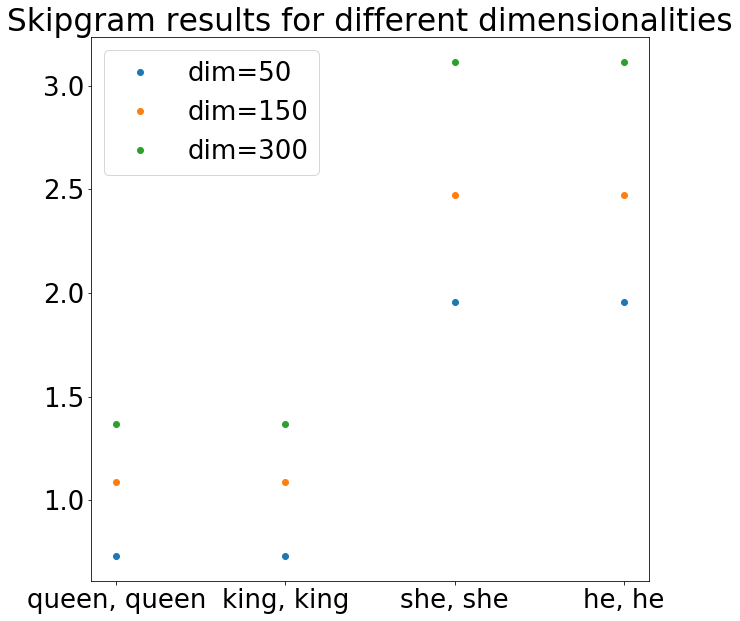

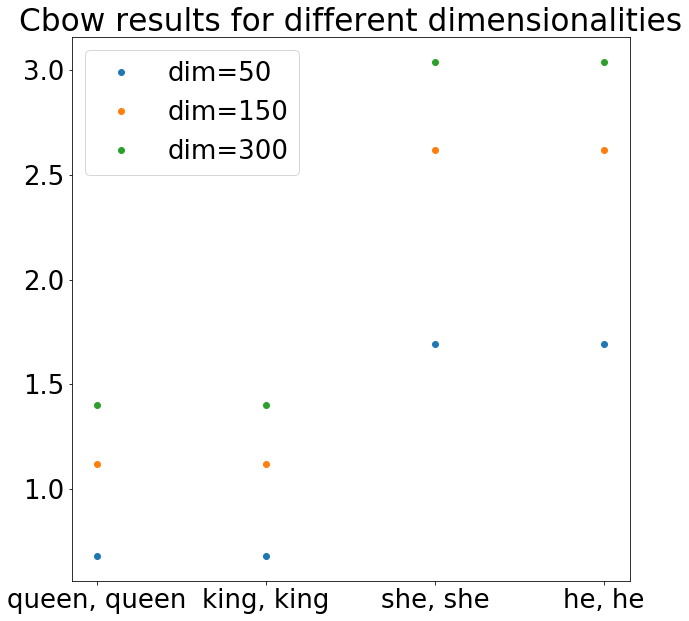

In [80]:

# simple plot to help interpret the results we got from our own analogy tests
x = [1, 2, 3, 4]

# result of skipgram with different dims compared with actual vector, e.g. queen vs queen
result_50_skip_self = [0.7303339, 0.7303339, 1.9561669, 1.956167]
result_150_skip_self = [1.087047, 1.087047, 2.4719436, 2.4719436]
result_300_skip_self = [1.3664021, 1.3664021, 3.1146085, 3.1146085]


# result of cbow with different dims compared with actual vector, e.g. queen vs queen
result_50_cbow_self = [0.6801358, 0.68013585, 1.6908765, 1.6908765]
result_150_cbow_self = [1.1198268, 1.1198268, 2.6200936, 2.6200936]
result_300_cbow_self = [1.4035616, 1.4035616, 3.0406723, 3.0406723]

ax = pyplot.subplot(1,1,1)
pyplot.plot(result_50_skip_self, 'o', label='dim=50')
pyplot.plot(result_150_skip_self, 'o', label='dim=150')
pyplot.plot(result_300_skip_self, 'o', label='dim=300')
locs, labels = pyplot.xticks()
pyplot.xticks([0, 1, 2, 3], ['queen, queen', 'king, king', 'she, she', 'he, he'])
pyplot.title('Skipgram results for different dimensionalities')
ax.legend()
pyplot.show()


ax = pyplot.subplot(1,1,1)
pyplot.rcParams["figure.figsize"] = [2,2]
pyplot.plot(result_50_cbow_self, 'o', label='dim=50')
pyplot.plot(result_150_cbow_self, 'o', label='dim=150')
pyplot.plot(result_300_cbow_self, 'o', label='dim=300')
locs, labels = pyplot.xticks()
pyplot.xticks([0, 1, 2, 3], ['queen, queen', 'king, king', 'she, she', 'he, he'])
pyplot.title('Cbow results for different dimensionalities')
ax.legend()
pyplot.show();



#skipgram predicts context words from target word, i.e. it predicts many words close to one word. Perhaps a small
#embedding dimension is not expressive enough to capture all word relations, and since we are predicting many words
#from one word, the performance is poor.

#on the other hand, cbow predicts one word from multiple context words, and a high embedding dimension in this case
#might lead to overfitting, and hence the performance is poor.

#CBOW : preferred for small corpus, faster
#SkipGram : preferred for large corpus and higher dimensions, slower.


In [16]:
vocabulary = dict(map(reversed, tokenizer.word_index.items()))


In [51]:
# BASED ON THE STORY, MAKE A LIST OF INTERESTING WORDS

interesting_words= ['rabbit',
#  'alice',
#  'watch',
 'longitude',
 'latitude',
 'cats',
 'bats',
 'mouse',
 'key',
 'lock',
 'garden',
 'flower',
 'custard',
 'turkey',
 'toffee',
 'toast',
 'flame',
 'candle',
 'door',
 'caterpillar',
 'mushroom',
 'butter',
 'soldiers',
#  'birds',
 'children',
 'puppy',
 'lizard',
 'duck',
 'animals',
 'kitchen', 'man', 'woman', 
#                     'he', 
#                     'she', 
                    'king', 'queen', ]

vocabulary_swapped = dict((v,k) for k,v in vocabulary.items())
vocabulary_swapped
interesting_words_indices= [vocabulary_swapped[x] for x in interesting_words]
print(interesting_words_indices)



[92, 1069, 1068, 285, 699, 113, 386, 1498, 235, 1348, 1518, 1522, 1523, 1525, 1527, 860, 151, 163, 454, 462, 377, 358, 514, 572, 738, 737, 796, 667, 1199, 73, 61]


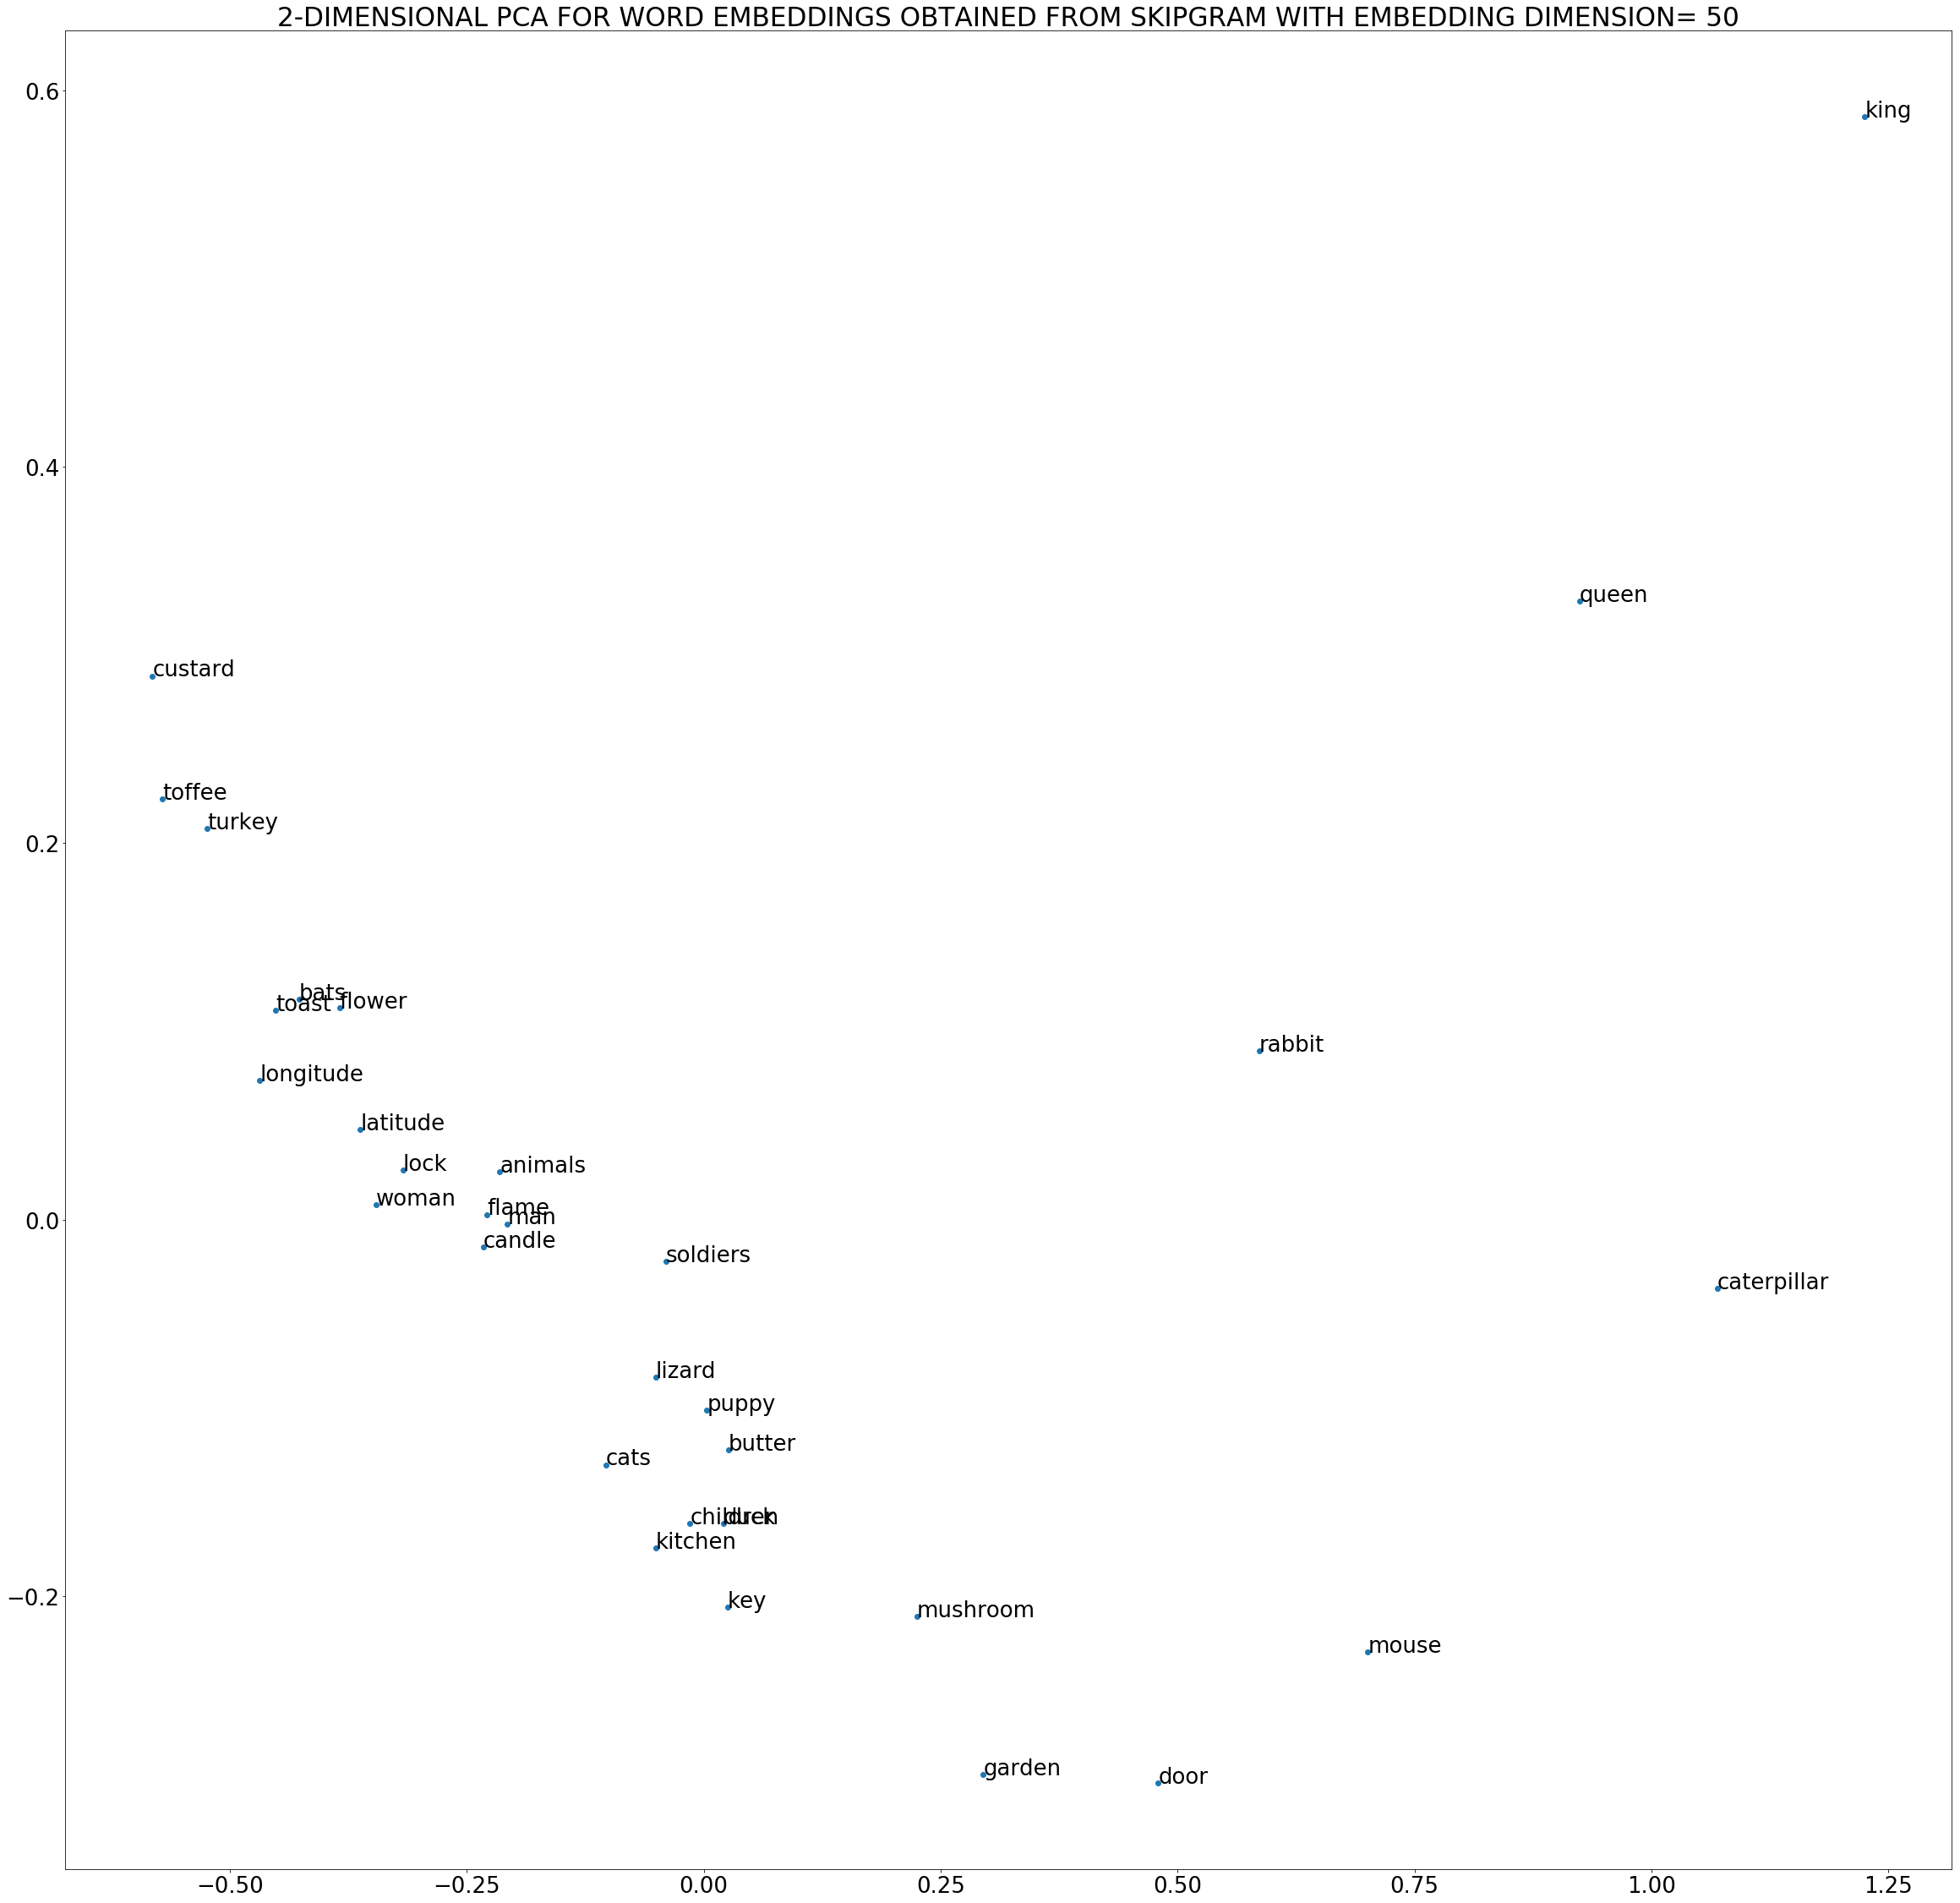

In [61]:
#Visualization results for Skipgram with embedding dimension=50

X= [skipGramEmbedding50[x] for x in interesting_words_indices]
# print(X.shape) #the shape of the embedding vector is (vocabulary size, embedding dimension)


pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
pyplot.title('2-DIMENSIONAL PCA FOR WORD EMBEDDINGS OBTAINED FROM SKIPGRAM WITH EMBEDDING DIMENSION= 50')
pyplot.rcParams["figure.figsize"] = [30,30]
# pyplot.rcParams.update({'font.size': 26})

for i, word in enumerate(interesting_words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

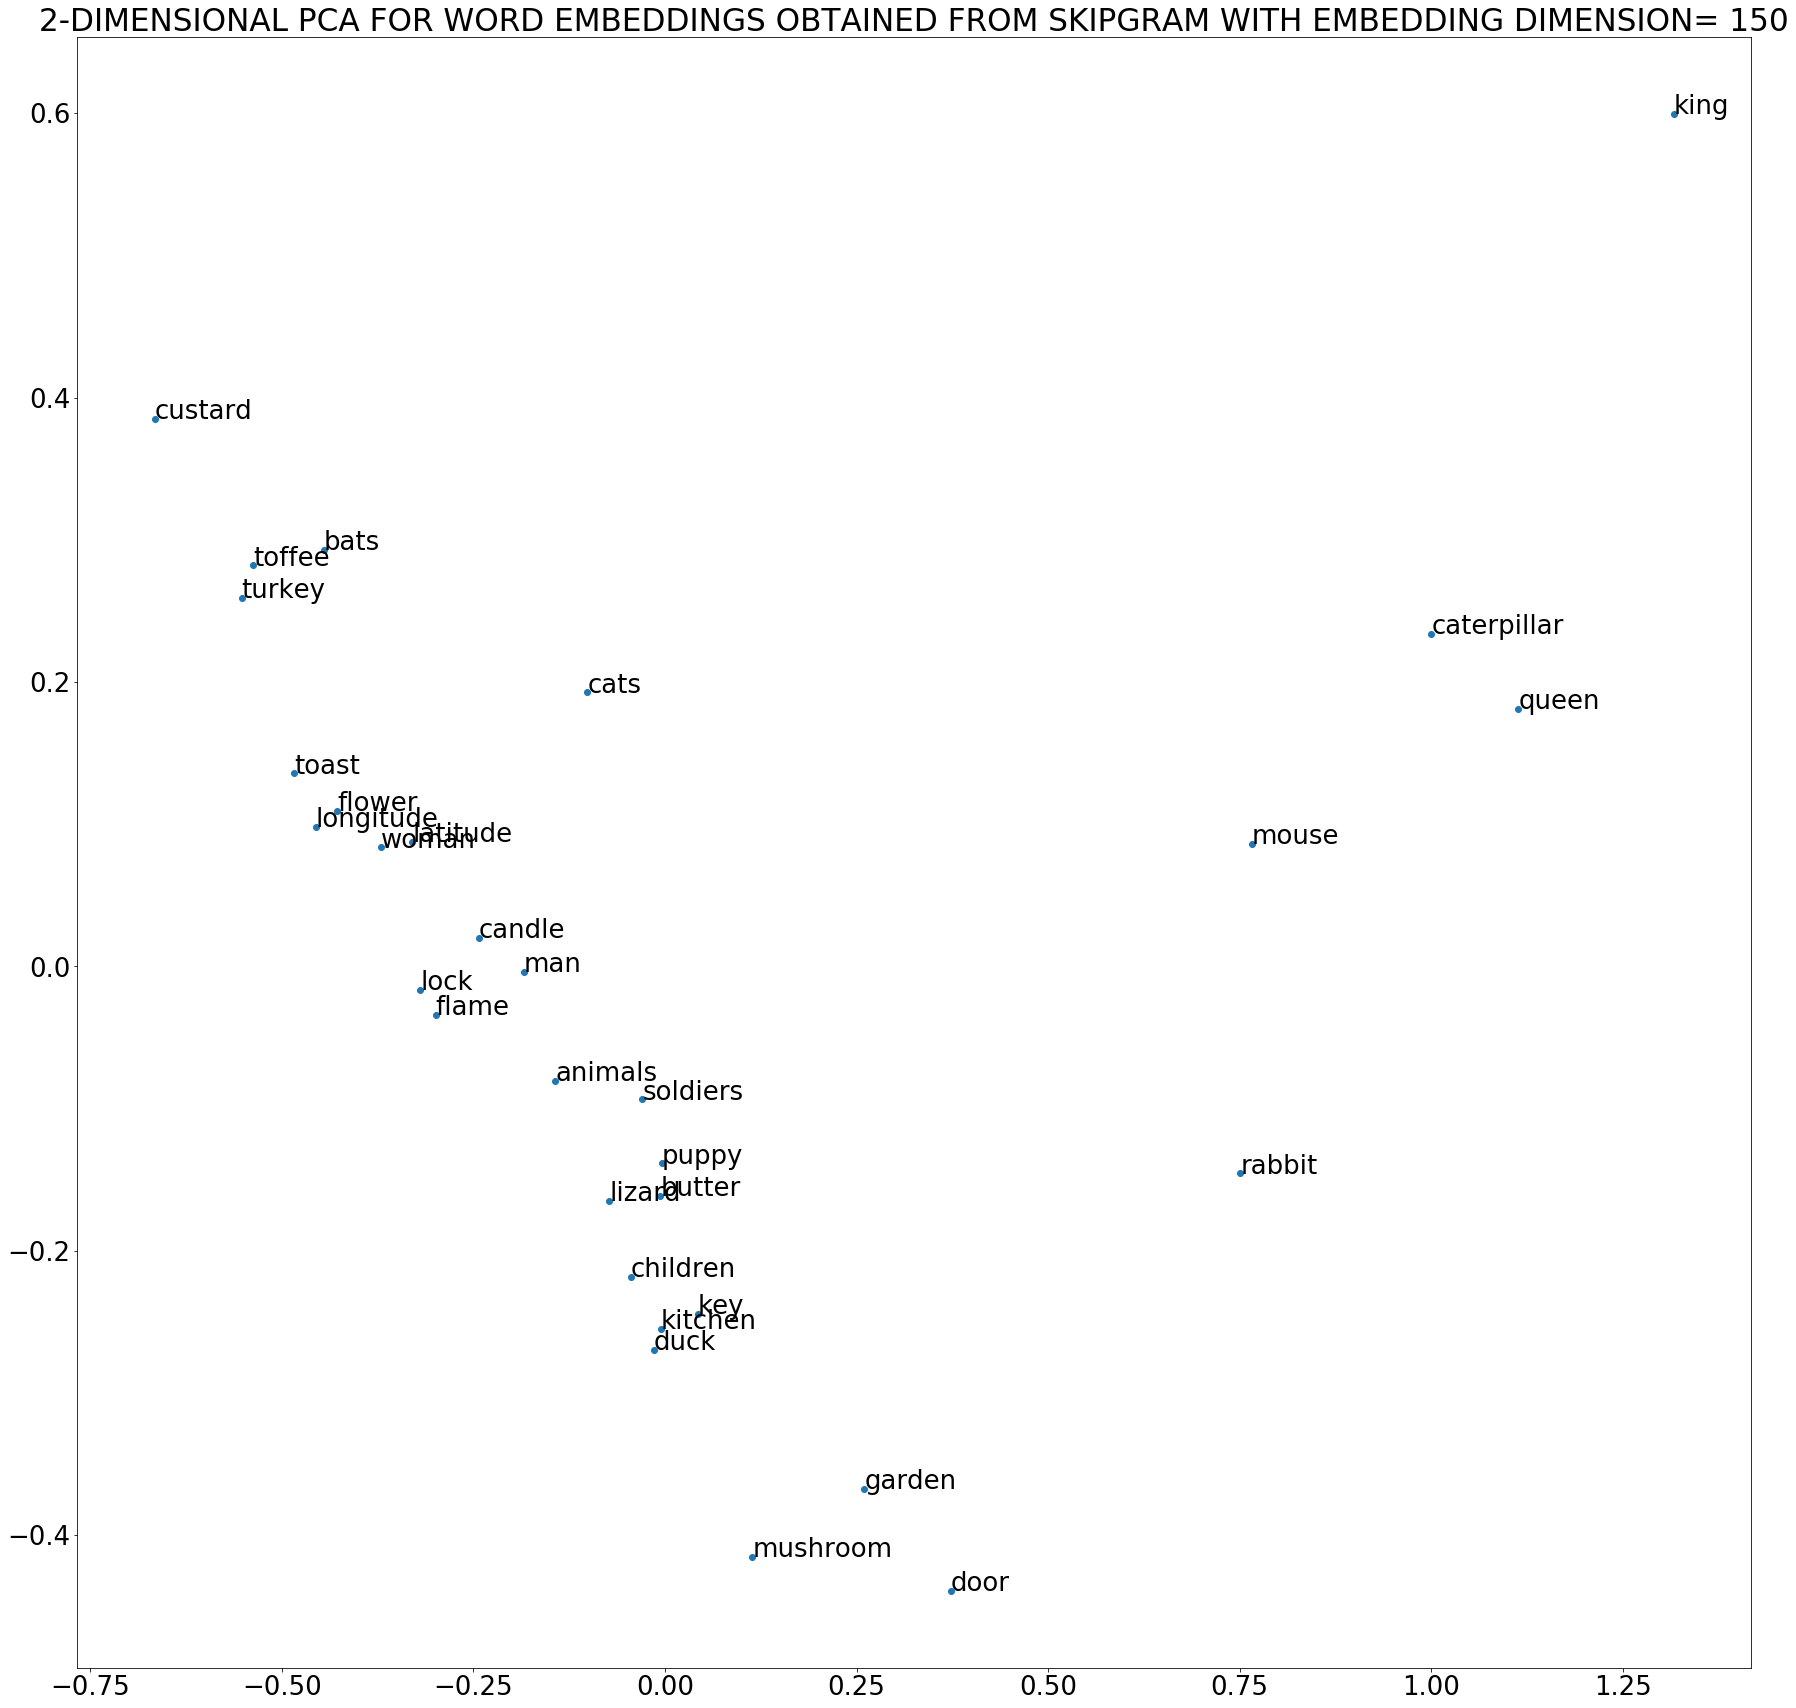

In [67]:
#Visualization results for Skipgram with embedding dimension=150

X= [skipGramEmbedding150[x] for x in interesting_words_indices]
# print(X.shape) #the shape of the embedding vector is (vocabulary size, embedding dimension)

pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
pyplot.title('2-DIMENSIONAL PCA FOR WORD EMBEDDINGS OBTAINED FROM SKIPGRAM WITH EMBEDDING DIMENSION= 150')
pyplot.rcParams["figure.figsize"] = [30,30]
# pyplot.rcParams.update({'font.size': 26})

for i, word in enumerate(interesting_words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

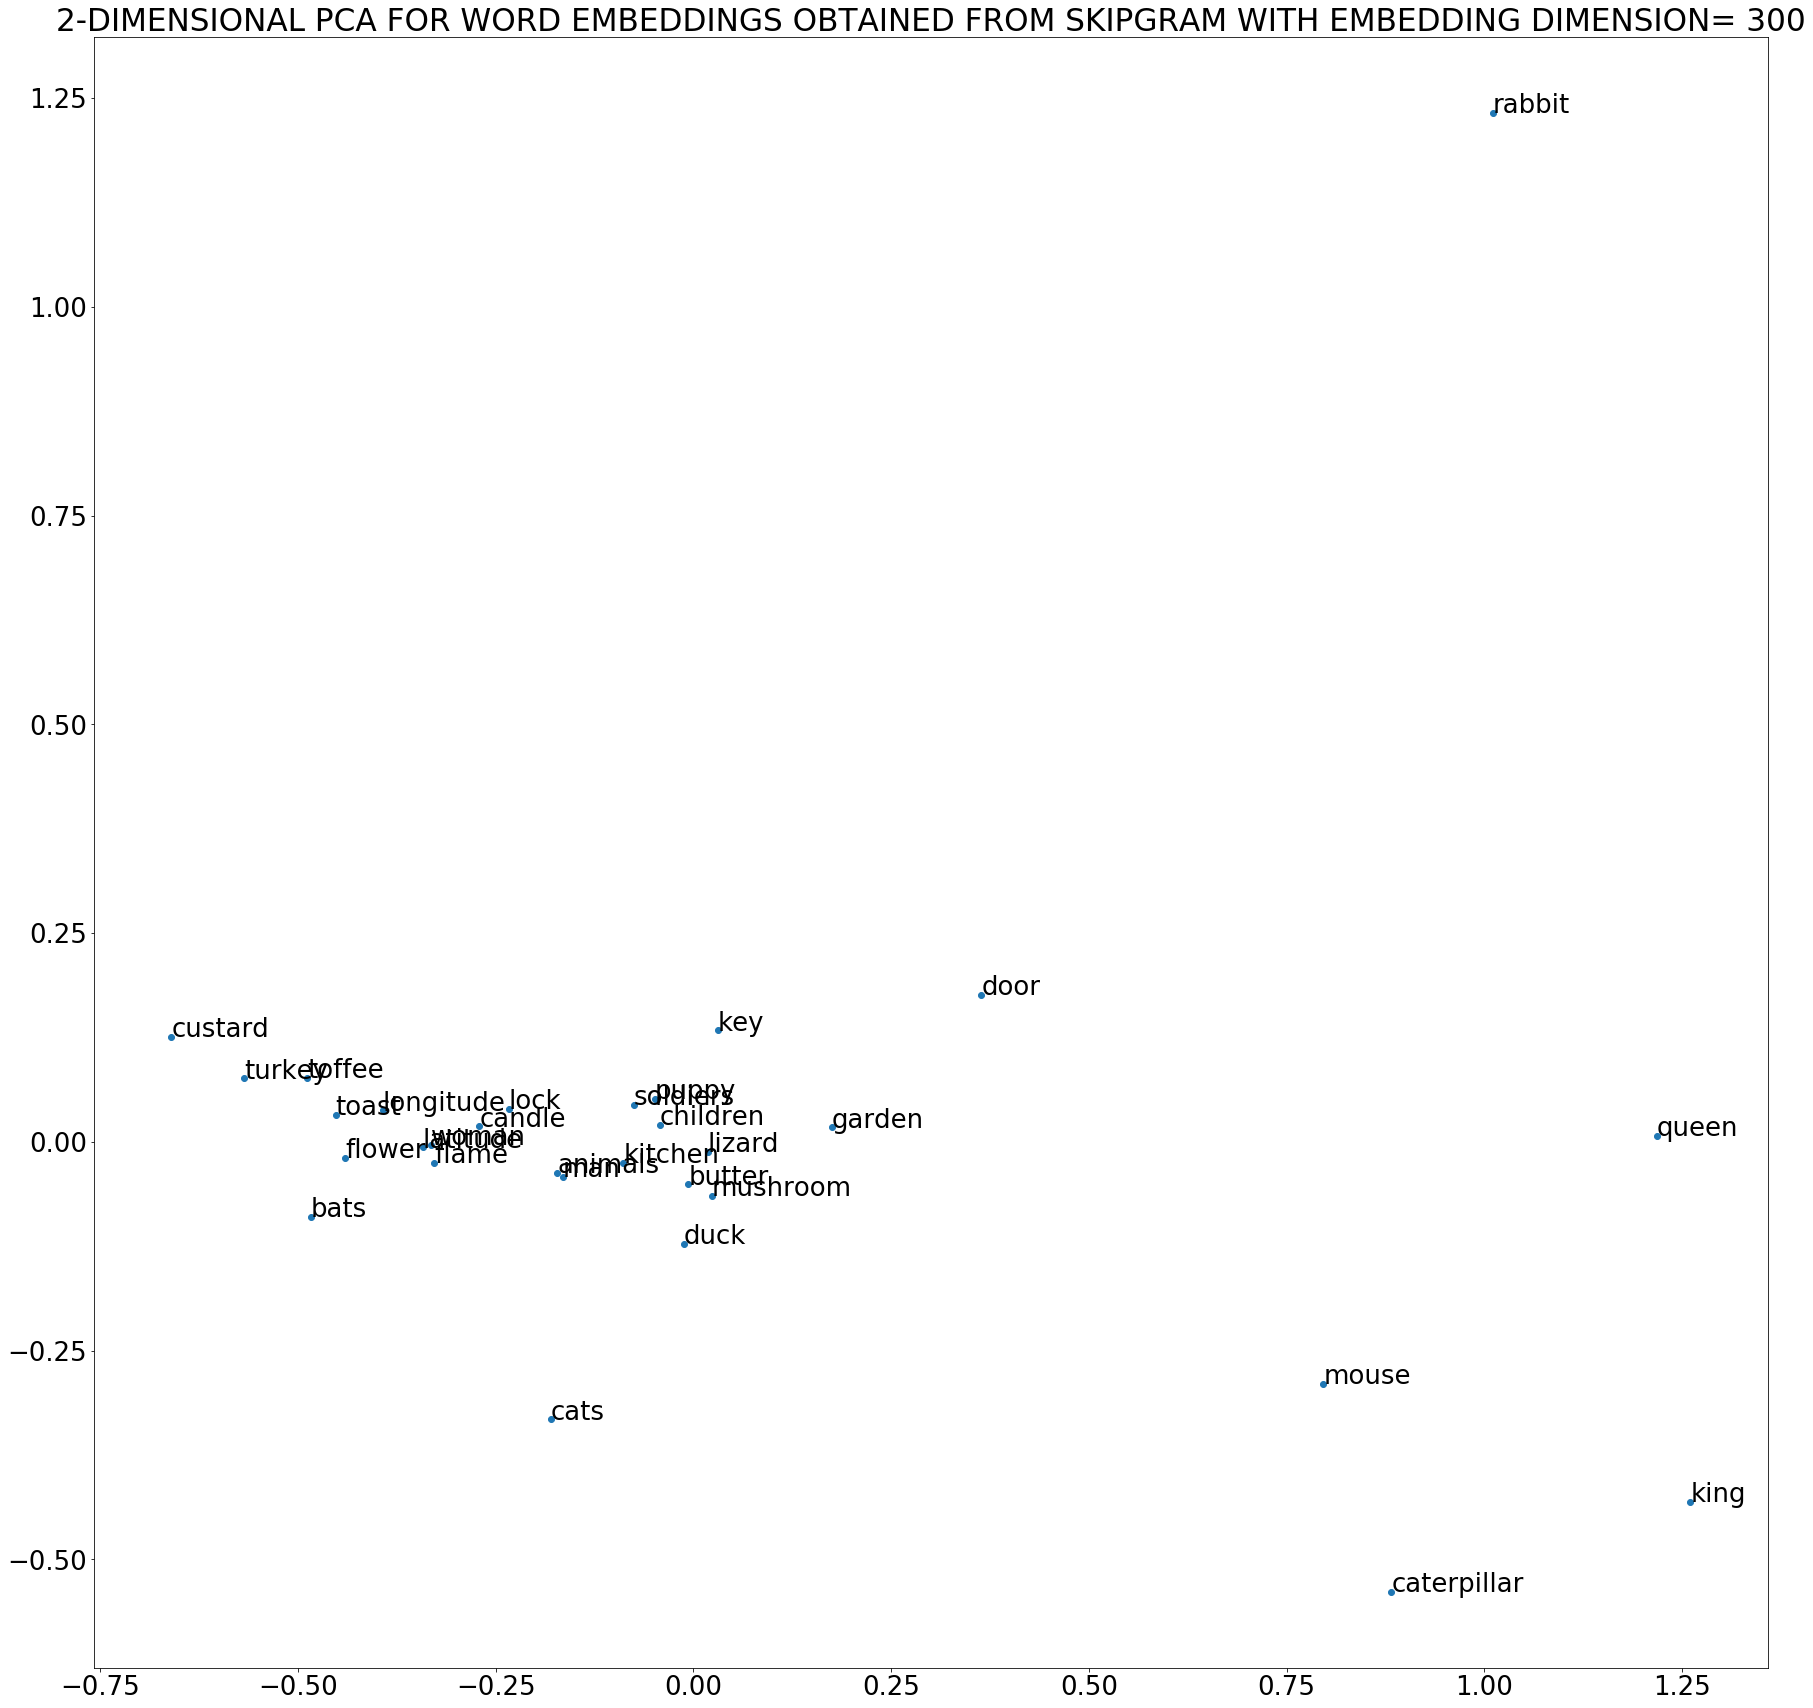

In [68]:
#Visualization results for Skipgram with embedding dimension=300

X= [skipGramEmbedding300[x] for x in interesting_words_indices]
# print(X.shape) #the shape of the embedding vector is (vocabulary size, embedding dimension)
pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
pyplot.title('2-DIMENSIONAL PCA FOR WORD EMBEDDINGS OBTAINED FROM SKIPGRAM WITH EMBEDDING DIMENSION= 300')
pyplot.rcParams["figure.figsize"] = [30,30]
# pyplot.rcParams.update({'font.size': 26})

for i, word in enumerate(interesting_words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

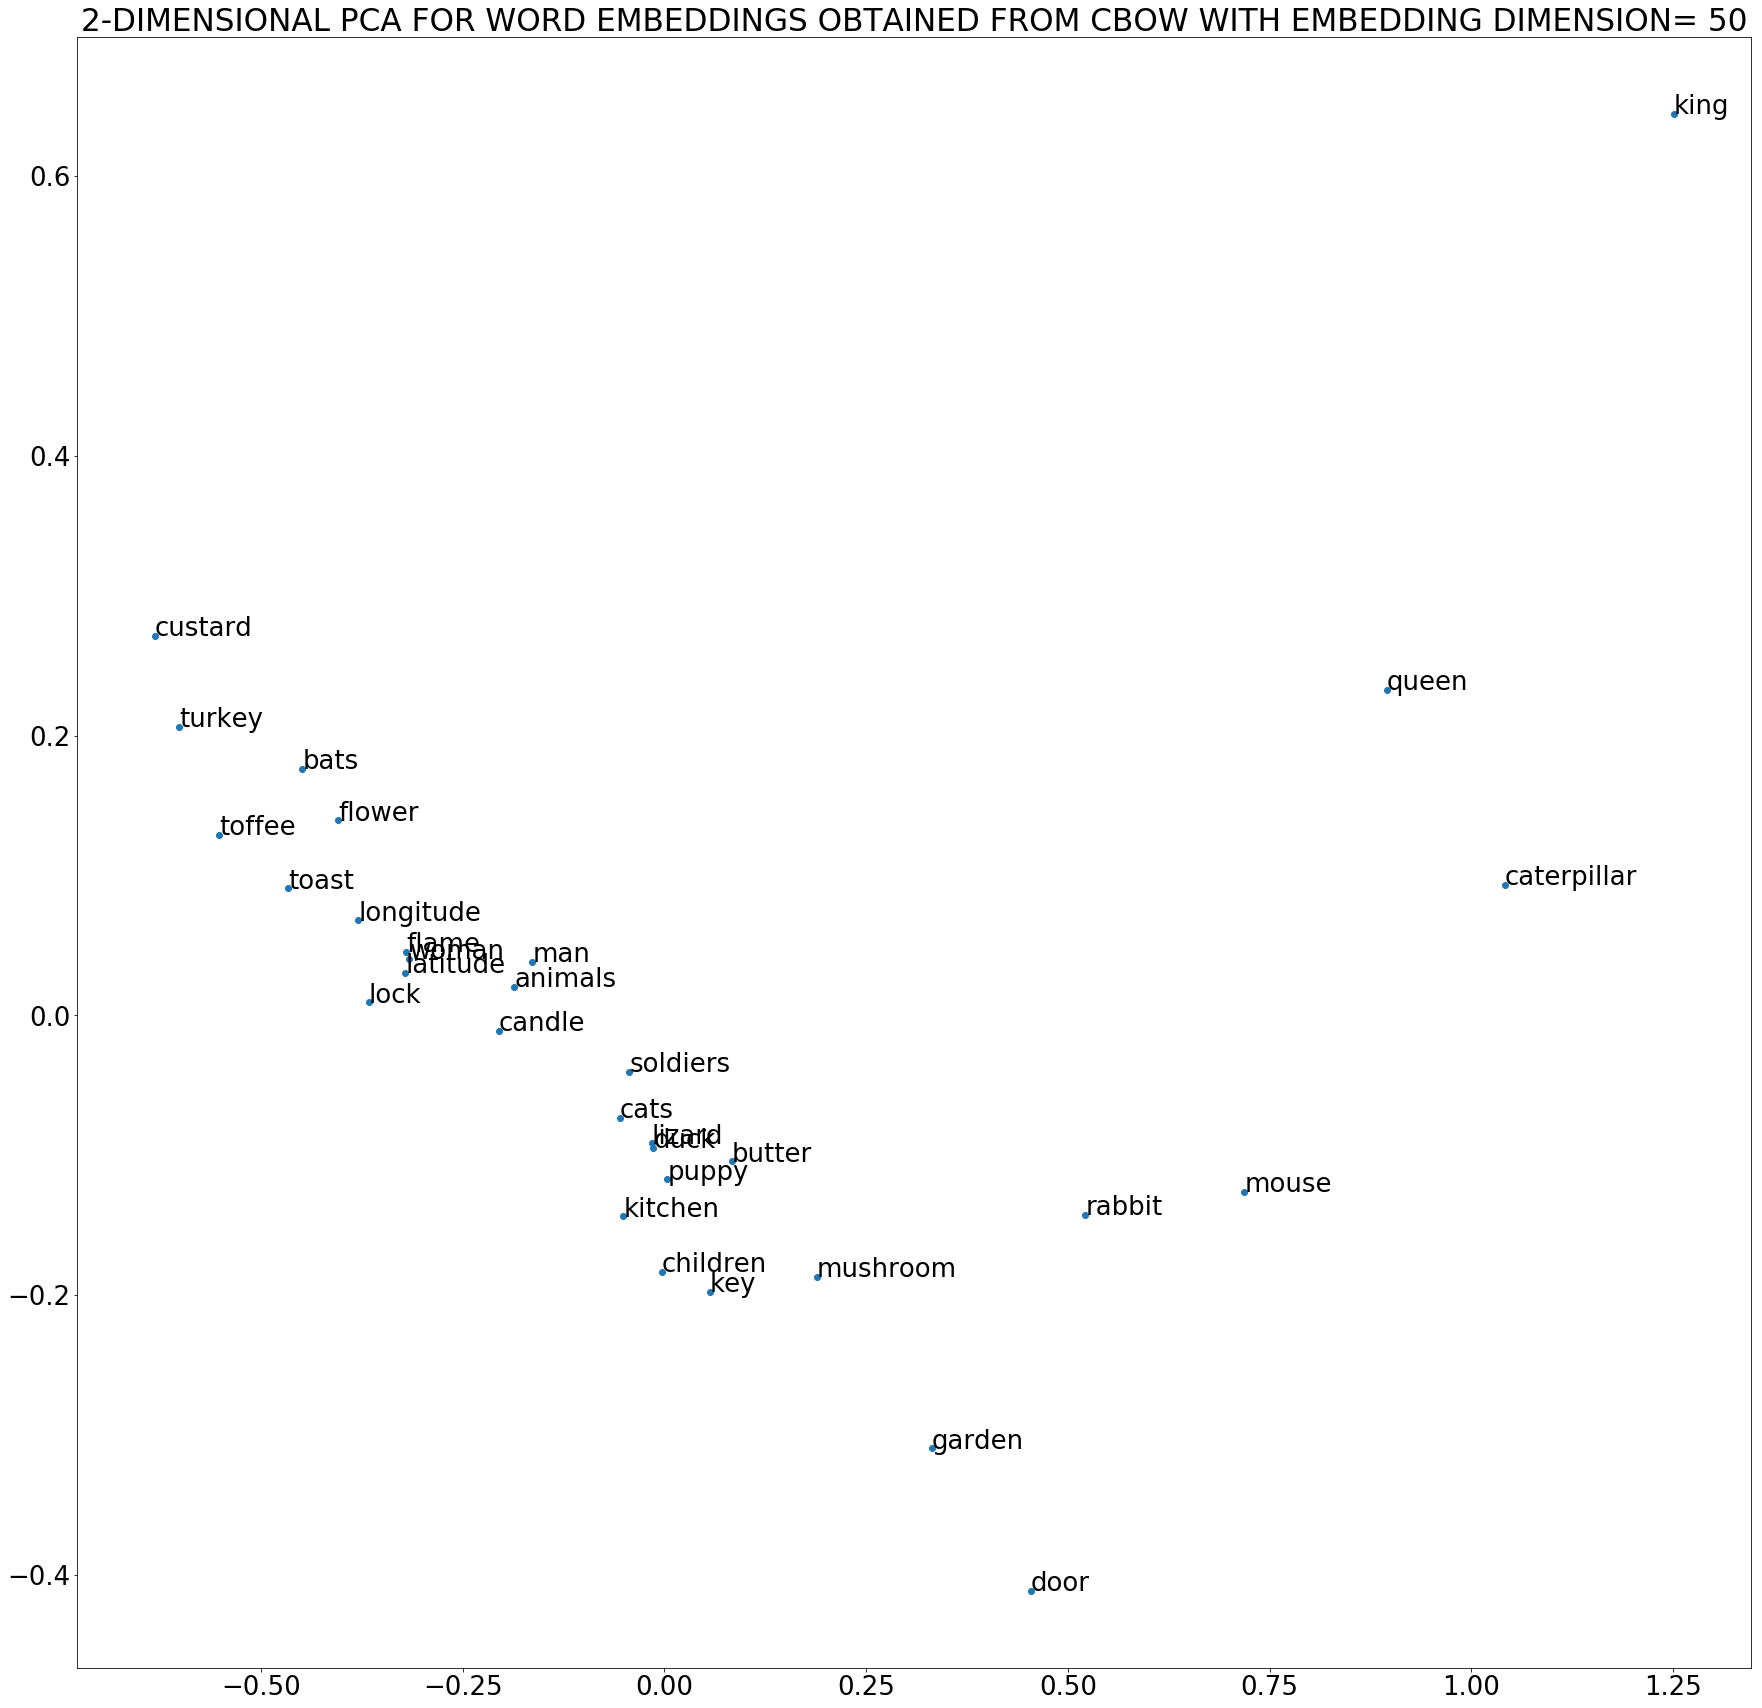

In [69]:
#Visualization results for CBOW with embedding dimension=50

X= [CBOWEmbedding50[x] for x in interesting_words_indices]
# print(X.shape) #the shape of the embedding vector is (vocabulary size, embedding dimension)


pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
pyplot.title('2-DIMENSIONAL PCA FOR WORD EMBEDDINGS OBTAINED FROM CBOW WITH EMBEDDING DIMENSION= 50')
pyplot.rcParams["figure.figsize"] = [30,30]
# pyplot.rcParams.update({'font.size': 26})

for i, word in enumerate(interesting_words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

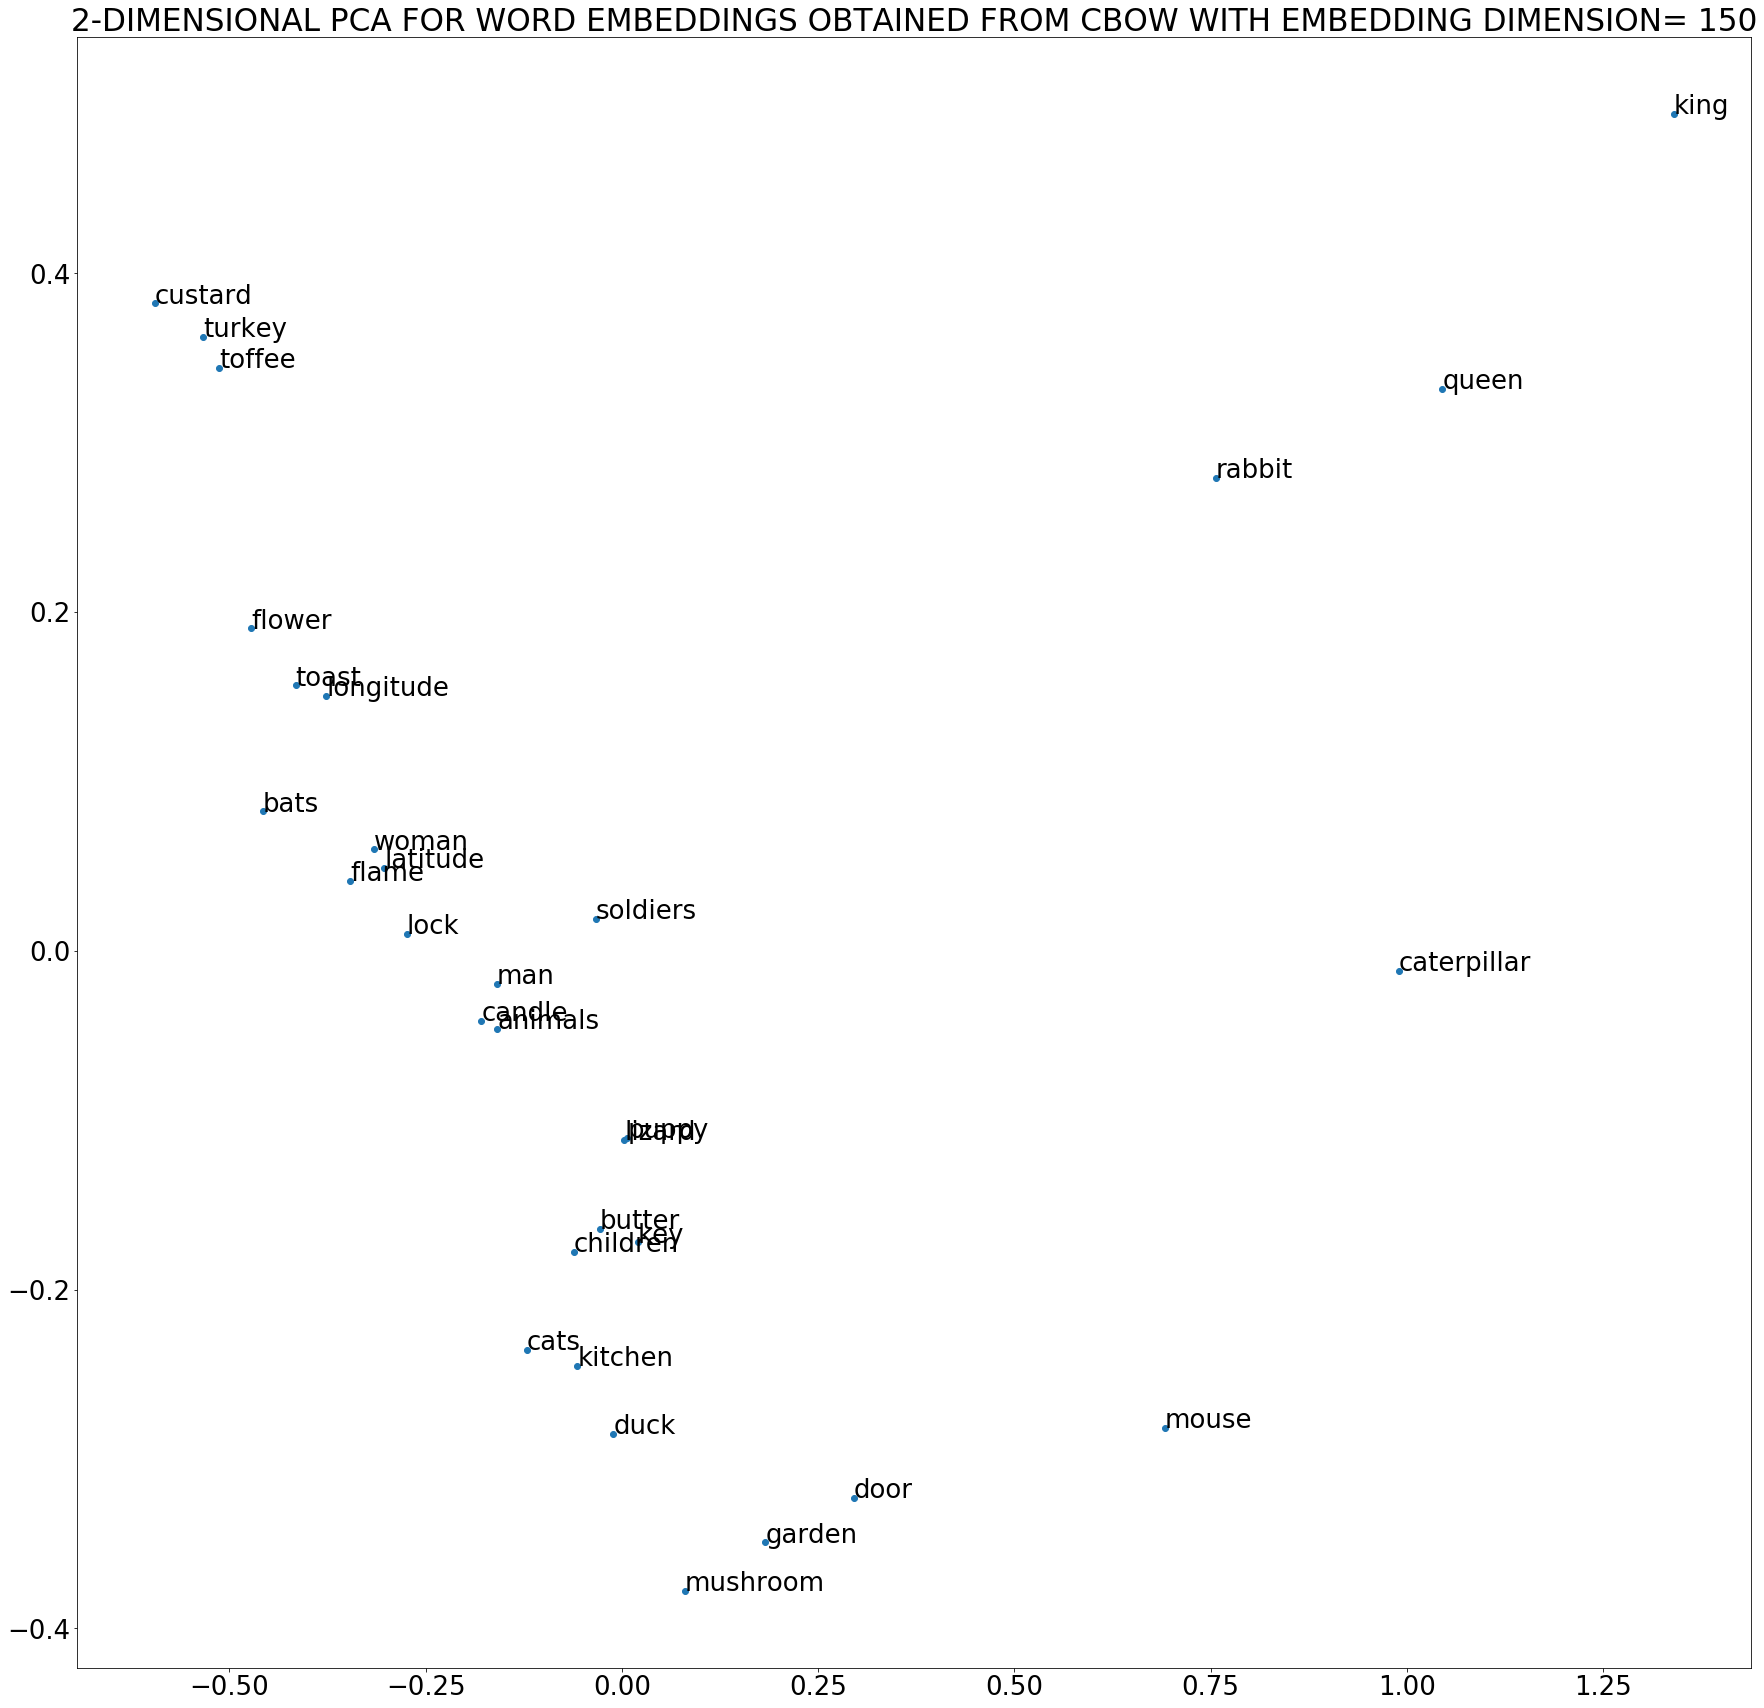

In [70]:
#Visualization results for CBOW with embedding dimension=150

X= [CBOWEmbedding150[x] for x in interesting_words_indices]
# print(X.shape) #the shape of the embedding vector is (vocabulary size, embedding dimension)


pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
pyplot.title('2-DIMENSIONAL PCA FOR WORD EMBEDDINGS OBTAINED FROM CBOW WITH EMBEDDING DIMENSION= 150')
pyplot.rcParams["figure.figsize"] = [30,30]
# pyplot.rcParams.update({'font.size': 26})

for i, word in enumerate(interesting_words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

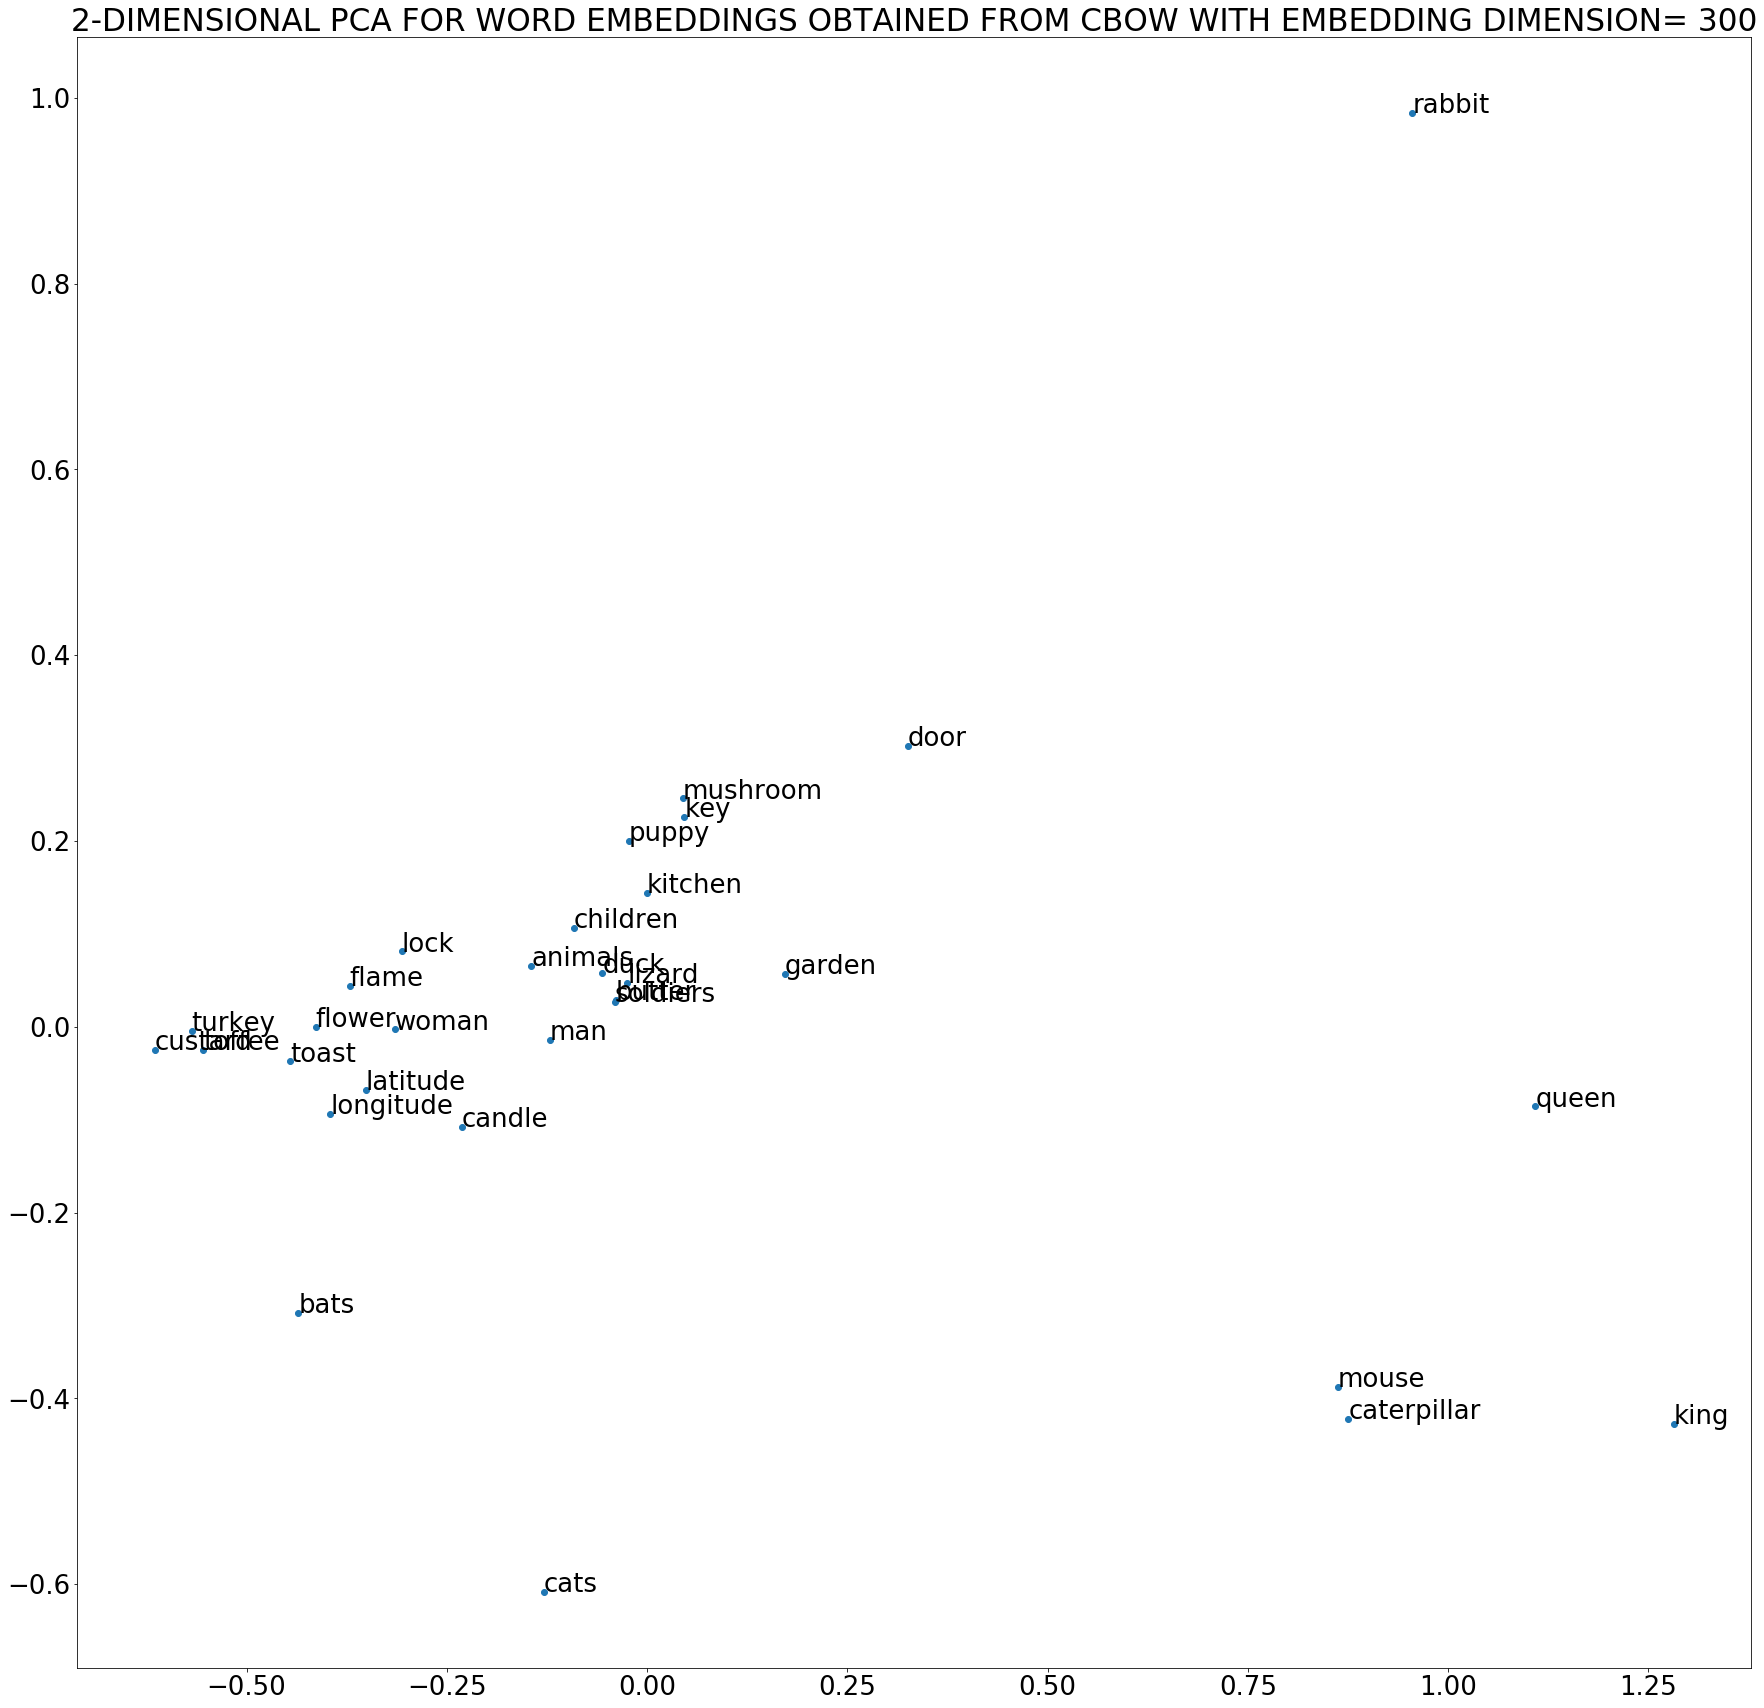

In [71]:
#Visualization results for CBOW with embedding dimension=300

X= [CBOWEmbedding300[x] for x in interesting_words_indices]
# print(X.shape) #the shape of the embedding vector is (vocabulary size, embedding dimension)


pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
pyplot.title('2-DIMENSIONAL PCA FOR WORD EMBEDDINGS OBTAINED FROM CBOW WITH EMBEDDING DIMENSION= 300')
pyplot.rcParams["figure.figsize"] = [30,30]
# pyplot.rcParams.update({'font.size': 26})

for i, word in enumerate(interesting_words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

Interpretation of Results

# Interpretation of distance results
From the distance between our analogy embeddings and the embeddings of the actual words we can already see that CBOW performs better than Skipgram on the smallest dimensionality of dim=50. For dim=150 Skipgram performs better than Cbow, and finally for dim=300 Skipgram performs better than Cbow on 'king' and 'queen' analogies, but worse on the 'she' and 'he' analogies. This leads us to believe that for infrequent words, SkipGram is better than CBOW. 

The frequency of the words 'king', 'queen', 'she' and 'he' are 62, 72, 125 and 551 respectively. In CBOW the accuracy is best with a low dimensionality of the embedding vector. In skipgram it seems to hold that higher dimensionalities are better, except for more frequent words. In that case CBOW performs better.

The fact that CBOW performs better than skipgram in the higher dimension can be explained by the claim that CBOW is generally better with more frequent words as opposed to less frequent words. This has to do with the fact that CBOW takes the sum of the embedded context word vectors to predict the target word. The chance that an infrequent word will be labeled as most probable is smaller than if the target word was a frequent word. This means that in the case that we are (unknowingly) trying to predict an infrequent word, we are less likely to pick that word, since CBOW will give priority to the more frequent ones. Skipgram is less sensitive to these factors. We think that the model is possibly overfitting when a higher embedding dimension is used, due to insufficient size of the training data.

The fact that CBOW performs worse on larger dimensions than Skipgram could be explained by the claim that CBOW relies on information from its neighboring words to do the embedding. It could be the case that larger vectors don't capture the information properly. Somehow the performance of Skipgram doesn't seem to increase with increasing dimension. 

In general we can conclude from our small tests that CBOW benefits from smaller dimensionality, whereas the opposite holds for skipgram.

# Interpretation of Visualization
From the visualizations, we find certain clusters of words being formed :

custard, toffee, turkey, toast - FOOD

latittude, longitude - GEOGRAPHY

Lizard, puppy, cats, duck, bats, animals - ANIMALS

Interestingly, the words mouse, caterpillar and rabbit are somewhat further away from the ANIMALS cluster. We know that these 3 words are frequent words in the corpus. Perhaps we need more training data in order to predict frequent words better. 

As expected from our analogy results, with CBOW, the king-queen distance decreases with increase in dimension. Further, for CBOW, lizard and duck are really close at dim = 50, and the distance prominently increases with dimension. These observations reinstate the fact that CBOW is better with higher dimensionality. 

# The main advantages and disadvantages of CBOW and Skipgram
Skipgram predicts context words from a target word, whereas CBOW predicts the word from the context. As mentioned before, we see that CBOW performs better on the smallest dimension (dim=50) than Skipgram. When the dimensionality increases, the performances notably diverge, where CBOW starts to perform worse than Skipgram. This could be explained by the fact that perhaps a small embedding dimension is not expressive enough to capture all word relations. The window-size might also have influence on this.

The benefit of both Skipgram and CBOW compared to other methods is that they make use of embeddings and thus they require less memory (since they don't need to do dense matrix multiplications), so that training is much quicker. Operations on this embedding are therefore also much quicker than if we were to use a regular matrix. 

In CBOW the words are averaged and then used to predict a word. Because of this, it can be hard for CBOW to predict rare words. Say we have a large corpus where there is a clear difference between rare and frequent words, it might do better at recognizing frequent words, and perform worse on infrequent words.

Skipgram doesn't do any averaging and therefore can, based on the rare word, possibly better predict the context words without being affected by the fact that it uses a rare word as input. To do this properly, it makes sense that it requires a larger corpus to properly learn the relationships. It has been shown that a larger corpus leads to better accuracy at the expense of training time. [1]

Lastly it is stated in [2] that the dimensionality of the word vector has a big impact on the performance of the word embedding. In particular they say that a word embedding with a small dimensionality is not expressive enough, whereas an embedding with a larger dimensionality is prone to over-fitting.


# References:

[1] Distributed Representations of Words and Phrases and their Compositionality. T. Mikolov, I. Sutskever, K. Chen, G. Corrado, J. Dean. NIPS'13 Proceedings of the 26th International Conference on Neural Information Processing Systems - Volume 2.

[2] On the Dimensionality of Word Embedding. Zi Yen and Yuanyuan Shen, 32nd Conference on Neural Information Processing Systems (NeurIPS 2018)